In [1]:
# Dependencies
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from modules.dataset.tweets import Tweets 
from modules.dataset.entities import Entities

%matplotlib inline

# Constants
years = [2017, 2018, 2019]

# Dataset creation

Once words and hashtags are extracted, they are stored in Pandas DataFrames with the following attributes:

1. <code> tweet_id </code> : Reference to the tweet ID
2. <code> entity_index </code> : Position of the word in the sentence (tweet) - useful to delete self loops 
3. <code> entity_text </code> : Text
4. <code> entity_tag </code> : Part Of Speech tag 
			

In [2]:
# Initialize Tweets class
tweets = Tweets()
# Fill tweets dataframe
tweets.from_json('data/db/tweets.json')

In [3]:
# Keep only tweets in english
# tweets.df = tweets.df[tweets.df.tweet_text.apply(lambda x: detect(x) == 'en')]
# Save english tweets
# tweets.df.to_json('data/db/tweets.json', )

tweets.df.shape

(14433, 3)

In [4]:
tweets.df.head()

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46\n1.Hong Kong\n2.#JointAddre...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,‘Shell knew’: oil giant's 1991 film warned of ...


In [5]:
# Initialize substitution dictionary
subs = {}
# Load hahstag substitutions
with open('data/hashtag_subs.json', 'r') as file:
    subs = {**subs, **json.load(file)}
# Load contact forms substitutions
with open('data/contract_forms.json', 'r') as file:
    subs = {**subs, **json.load(file)}

In [6]:
# Get hashtags and words datasets
hashtags, words = tweets.get_entities(subs=subs)

# OR load hashtags from json
# hashtags = Entities()
# hashtags.df = pd.read_json('data/db/hashtags.json')

hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
226315,1101574442575167489,48,#ClimateChange,#,0.9615
226316,1101574442575167489,49,#Science,#,0.9843
226236,1101574446341607424,10,#climatechange,^,0.4659
226252,1101574446341607424,26,#climateemergency,#,0.2876
226198,1101574471247380480,16,#climatechange,N,0.5529


In [7]:
# OR load words from json
# words = Entities()
# words.df = pd.read_json('data/db/words.json')
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
208036,1101574442575167489,0,"""",",",0.9852
208037,1101574442575167489,1,our,D,0.9937
208038,1101574442575167489,2,ability,N,0.9969
208039,1101574442575167489,3,to,P,0.9993
208040,1101574442575167489,4,detect,V,0.9977


In [8]:
# Save data
hashtags.to_json('data/db/hashtags.json')
words.to_json('data/db/words.json')

## Words filtering

In [9]:
# Recognize pronouns and clean from symbols
words.clean_entities()

In [10]:
# Automatically and manually found pronouns
words.df[words.df.entity_tag == 'O'].shape[0]

13544

In [11]:
# Manually found pronouns
words.df[(words.df.entity_conf == 1.0) & (words.df.entity_tag == 'O')].shape[0]

13468

In [12]:
# Filter on POS tag
words.df = words.df[words.df.entity_tag.isin(['N', 'V', 'R', 'A', 'O', 'S'])]
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
208037,1101574442575167489,1,our,O,1.0000
208038,1101574442575167489,2,ability,N,0.9969
208040,1101574442575167489,4,detect,V,0.9977
208042,1101574442575167489,6,monitor,V,0.7321
208044,1101574442575167489,8,movement,N,0.9997


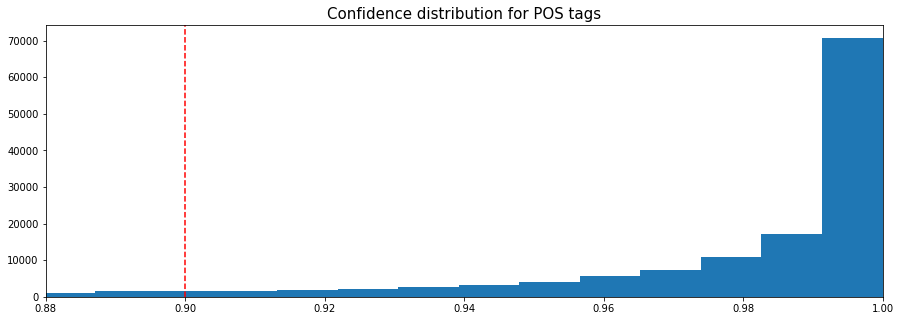

There are 29771 (18.81%) words under 0.90 confidence interval
There will be 128512 (81.19%) words remaining inside 0.90 confidence interval


In [13]:
# Set threshold on confidence
conf = 0.9

# Show confidence distribution
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.df.entity_conf, bins=100)
_ = ax.set_xlim(left=0.88, right=1.0)
_ = ax.axvline(x=conf, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

# info
print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.df.entity_conf < conf), sum(words.df.entity_conf < conf) / words.df.shape[0] * 100, conf
))
# info
print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.df.entity_conf >= conf), sum(words.df.entity_conf >= conf) / words.df.shape[0] * 100, conf
))

In [14]:
# Filter on confidence
words.df = words.df[words.df.entity_conf >= conf]

In [15]:
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
208037,1101574442575167489,1,our,O,1.0000
208038,1101574442575167489,2,ability,N,0.9969
208040,1101574442575167489,4,detect,V,0.9977
208044,1101574442575167489,8,movement,N,0.9997
208051,1101574442575167489,15,abominable,A,0.9962


In [16]:
# Number of pronouns after cleaning
words.df[words.df.entity_tag == 'O'].shape[0]

13501

In [17]:
# Save words data
words.to_json('data/db/words.json')

In [21]:
words.df[words.df.entity_text == 'making']

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
255233,1107683197998039041,8,making,V,0.9962
